# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.auto import tqdm
import os

In [2]:
!export CUDA_LAUNCH_BLOCKING=1
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## For Google Colab Users

This cell is for mounting your Google Drive to the Colab Notebook. If you are not using Google Colab, you can skip this cell

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Check for GPU in mac
# device = "mps" if torch.backends.mps.is_available() else "cpu"

device

'cuda'

# Data 

## Transforming Data

In [5]:
data_transforms = {

    'Training' : transforms.Compose([
        transforms.RandomResizedCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'Testing': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()

    ])
}

## Loading Data

In [6]:
# directory: where training and testing data are
# base_path = '/content/drive/MyDrive/Colab Datasets/MRI/'
base_path = '/content/drive/MyDrive'
data_dir = os.path.join(base_path, 'CI')

### START CODE HERE

# datasets.ImageFolder: (https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html)
# torch.utils.data.DataLoader: (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

# image_datasets are dictionary of (type of dataset, dataloader)
# type of dataset are training and testing
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}

# DataLoader helps us for better performance and experience in data loading
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 64, shuffle=True) for x in ['Training', 'Testing']}
### END CODE HERE

dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes

dataset_sizes, class_names

({'Training': 2770, 'Testing': 394},
 ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

## Samples of data

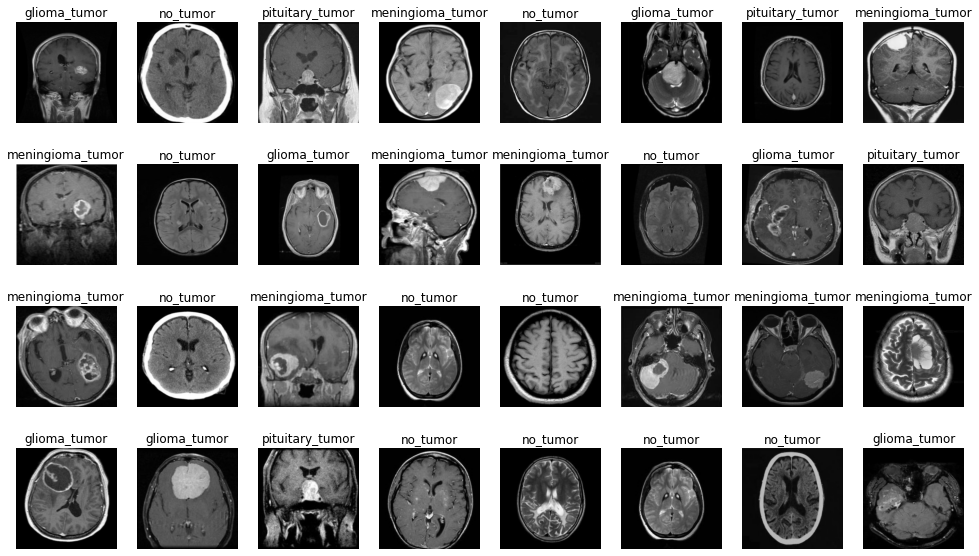

In [7]:
samples, labels = next(iter(dataloaders['Testing']))
plt.figure(figsize=(17, 10))
plt.axis('off')
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(samples[i].permute(1, 2, 0))
    plt.title(class_names[labels[i]])
    plt.axis('off')

# Model

## Loading Model

In [8]:
# Loading are pretrained model in this task our model is resnet50 (https://www.youtube.com/watch?v=mGMpHyiN5lk)
### START CODE HERE

# Loading pretrained model
model = models.resnet50(pretrained = models.resnet50(weights = models.ResNet50_Weights.DEFAULT))
for param in model.parameters():
    param.requires_grad = False
### END CODE HERE
# model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Preparing Model

In [9]:
### START CODE HERE
out_features = 4

# You have to change the (fc) layer of the model to compatible with your data
model.fc = nn.Linear(model.fc.in_features, out_features)

### END CODE HERE
model = model.to(device)
# model

# Training

## Loss function

In [10]:
criterion = nn.CrossEntropyLoss()

## Optimizer

In [11]:
# you have to change it for better performance
# optimizer = optim.Adam(model.parameters(), lr = 1e-3)
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

## Others

In [12]:
# you can have other thongs like learning rate scheduler and ...

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 300)

## Train

In [ ]:
### START CODE HERE

losses = []
EPOCH = 20

# for training part you have to set model to train mode
model.train()

# loop on epochs
for e in tqdm(range(EPOCH)):

  # loop on batches
  for inputs, labels in dataloaders['Training']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # set the grad to zero
    optimizer.zero_grad()
    
    # forward part
    # hint: using of pytorch max method (https://pytorch.org/docs/stable/generated/torch.max.html)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    #  compute loss
    loss = criterion(outputs, labels)
    
    # backward part
    loss.backward()

    # update parameters
    optimizer.step()

  scheduler.step()

  # you have to append loss for each epoch
  losses.append(loss.item())
### END CODE HERE

  0%|          | 0/20 [00:00<?, ?it/s]

## Plot loss function

In [ ]:
# you have to calculate losses arrayin Train part
plt.plot(list(range(len(losses))), losses)
plt.show()

## Evaluate model

In [ ]:
### START CODE HERE

def calc_accuracy(data, model):
  corrects = 0

  # for testing part you have to set model to eval mode
  model.eval()
  for inputs, labels in tqdm(dataloaders[data]):
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)
  return corrects.double() / dataset_sizes[data]

### END CODE HERE

In [ ]:
# accuracy of training data
calc_accuracy('Training', model)

In [ ]:
# accuracy of testing data
calc_accuracy('Testing', model)

# Saving Model

In [ ]:
PATH = os.path.join(base_path, 'model')
torch.save(model.state_dict(), PATH)

# Loading and eval Model

In [ ]:
### START CODE HERE

model_for_eval = models.resnet50(pretrained = True)
model_for_eval.fc = nn.Linear(model.fc.in_features, 4)
model_for_eval.to(device)
model_for_eval.load_state_dict(torch.load(PATH))

### END CODE HERE

In [ ]:
# model_for_eval

In [ ]:
# accuracy of training data by loadded model
calc_accuracy('Training', model_for_eval)

In [ ]:
# accuracy of testing data by loadded model
calc_accuracy('Testing', model_for_eval)